# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.


## Problem Statement

Determine customer churn for a music streaming company called Sparkify. The users stream their favorite songs either using the free tier that place advertisements between songs or use the premium plan for which they pay a monthly fee with no advertisements between songs. Users can upgrade, downgrade or cancel their services. The dataset given to us contains a log of the activities of each user on the service whether they are playing songs, logging out, upgrading their service or cancelling the service. All this data contains key insights in keeping the users of the service happy. Our task in this project is to develop a model that predict which users are at risk. If we can identify users that are at risk to churn either by downgrading from premium or by cancelling their service, the business can offer them incentives and discounts potentially saving millions in revenues or maximize revenues.

I will be using pyspark and different classification models for predicting the customer churn

### Metric

We will be using F1 score as there is a highly imbalanced, i.e. the number of churned users is very small compared to number of active users.

In [1]:
# import libraries
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, avg, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

from pyspark.sql.types import IntegerType
import pyspark.sql.functions as psqf
import pyspark.sql.types as psqt

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# changing the default figure size of the plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
#reading the json to a dataframe
sparkify_df = spark.read.json('mini_sparkify_event_data.json')

In [5]:
#checking if there are any missing values, but we didn't check for any empty values which we will see in the next cell
sparkify_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sparkify_df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



There are no missing values (NaNs) in our dataset. If there are missing values in any column, we can use filter function to remove those or dropna function based on columns or rows. But still there are empty values, lets explore

In [6]:
sparkify_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Converting Spark DataFrame to Pandas DataFrame
sparkify_dfp = sparkify_df.toPandas()
sparkify_dfp.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [8]:
sparkify_dfp.tail()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
286495,None,Logged Out,None,None,41,None,NaN,paid,None,GET,Home,NaN,500,None,200,1543622240000,None,
286496,None,Logged Out,None,None,42,None,NaN,paid,None,PUT,Login,NaN,500,None,307,1543622241000,None,
286497,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1.538337e+12,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
286498,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1.538337e+12,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
286499,Camera Obscura,Logged In,Emilia,F,45,House,170.89261,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1.538337e+12,500,The Sun On His Back,200,1543622411000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


In [9]:
print("There are about {} rows with empty value in userId".format(sparkify_dfp[sparkify_dfp['userId'] == ''].shape[0]))

There are about 8346 rows with empty value in userId


In [10]:
#removing empty values from userId column
sparkify_dfp = sparkify_dfp[~(sparkify_dfp.userId == '')].reset_index(drop=True)

Removed rows where there are empty values in the dataframe. There are no empty sessionIds

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

Assuming `Cancellation Confirmation` events are customers churning, as of now

In [11]:
print("Number of user transactions: {}".format(sparkify_dfp.shape[0]))
print("Number of user columns: {}".format(sparkify_dfp.shape[1]))

Number of user transactions: 278154
Number of user columns: 18


##### What is the number of users who have Cancellation Confirmation?

In [12]:
users_churned = list(set(sparkify_dfp[sparkify_dfp['page'].isin(['Cancellation Confirmation'])]['userId'].unique()))

In [13]:
len(users_churned)

52

There are 52 users who cancelled confirmation the service. We can also consider users who 'Submit Downgrade', "Cancel" and "Downgrade" as churned

In [14]:
sparkify_dfp['churn'] = sparkify_dfp['userId'].apply(lambda user: 1 if user in users_churned else 0)

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
#columns and their datatypes
sparkify_dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 19 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null float64
sessionId        278154 non-null int64
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
churn            278154 non-null int64
dtypes: float64(2), int64(5), object(12)
memory usage: 40.3+ MB


In [16]:
#total number of users
print("There are {} unique users".format(len(sparkify_dfp.userId.unique().tolist())))

There are 225 unique users


##### Distribution of different categorical variables

Below is the distribution for column userId
   churn  userId_count
0      0           173
1      1            52


Text(0.5,0,'userId_count')

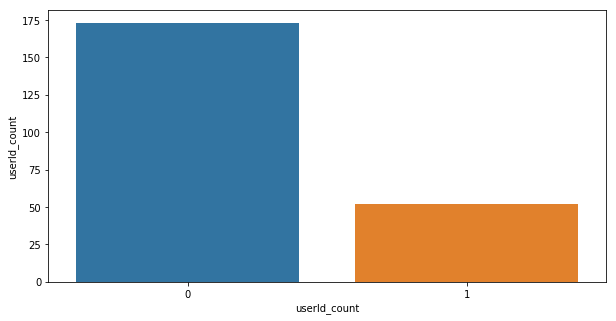

In [17]:
print("Below is the distribution for column {}".format('userId'))
df_temp = sparkify_dfp.drop_duplicates(subset='userId').groupby(['churn'])['userId'].count().reset_index().rename(columns={'churn': 'churn', 'userId': 'userId_count'})
col_cnt = list(set(df_temp.columns.tolist()) - set(['churn']))[0]
print(df_temp)
ax = sns.barplot(x='churn', y='userId_count', data=df_temp, ci=None)
ax.set_xlabel(col_cnt)

There is a class imbalance, we need to carefully handle the modeling part

Below is the distribution for column level


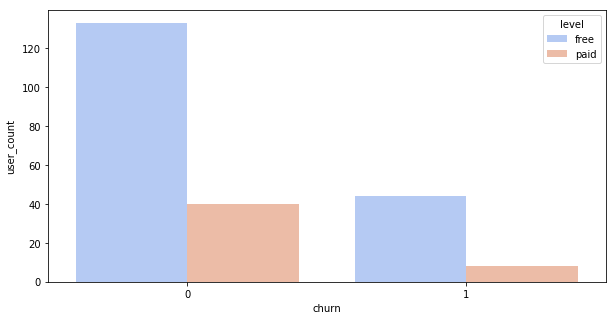

In [18]:
#distribution of levels and churned users
print("Below is the distribution for column {}".format('level'))
df_temp = sparkify_dfp.drop_duplicates(subset=['userId']).groupby(['level','churn'])['churn'].count().reset_index(level='level')
df_temp.columns = ['level','user_count']
df_temp = df_temp.reset_index()
sns.barplot(x="churn",y="user_count",hue="level",data=df_temp, palette="coolwarm")

In [19]:
sparkify_dfp.level.value_counts()

paid    222433
free     55721
Name: level, dtype: int64

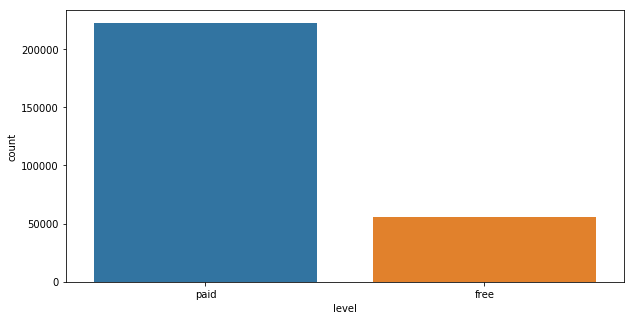

In [20]:
ax = sns.countplot(x="level", data=sparkify_dfp)

We can see there are more users who take free subscription and then cancel when subscription ends

Below is the distribution for column level


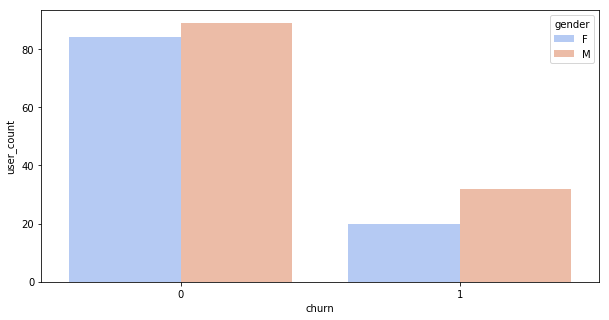

In [21]:
#distribution of levels and churned users
print("Below is the distribution for column {}".format('level'))
df_temp = sparkify_dfp.drop_duplicates(subset=['userId']).groupby(['gender','churn'])['churn'].count().reset_index(level='gender')
df_temp.columns = ['gender','user_count']
df_temp = df_temp.reset_index()
sns.barplot(x="churn",y="user_count",hue="gender",data=df_temp, palette="coolwarm")

There are approximately equal male and female who didnt cancel confirmation. But more number of cancel confirmations by Male who churned

In [22]:
#duplicated rows
sparkify_dfp[sparkify_dfp.duplicated()]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn


There are no duplicated rows

##### Page Distribution

In [23]:
df_temp = sparkify_dfp['page'].value_counts().reset_index().rename(columns={'index': 'page', 'page': 'count'})

Text(0.5,0,'count')

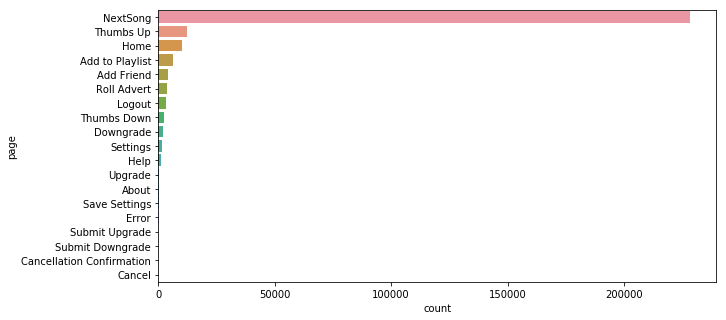

In [24]:
ax = sns.barplot(x="count", y="page", data=df_temp, ci=None)
ax.set_xlabel('count')

Users listen to songs more often, hence "NextSong" is more. Followed by Home, Thumbs up, Add to playlist.

Text(0.5,0,'count')

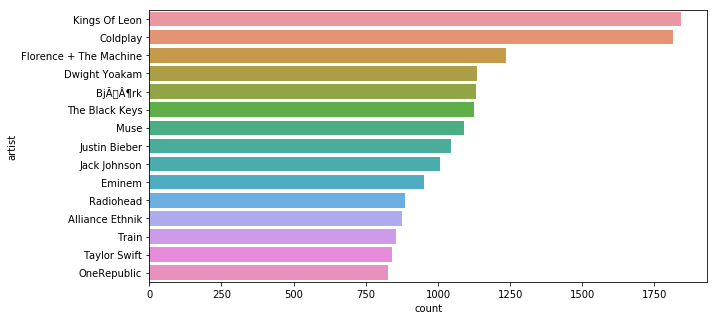

In [25]:
# top 15 artists users listen to
df_temp = sparkify_dfp.artist.value_counts()[:15].reset_index().rename(columns={'index': 'artist', 'artist': 'count'})
ax = sns.barplot(x="count", y="artist", data=df_temp, ci=None)
ax.set_xlabel('count')

Users prefer mostly Kings Of Leon and Coldplay

In [26]:
sparkify_dfp.groupby(['auth','churn'])['churn'].count()

auth       churn
Cancelled  1            52
Logged In  0        233290
           1         44812
Name: churn, dtype: int64

Below is the distribution for column auth


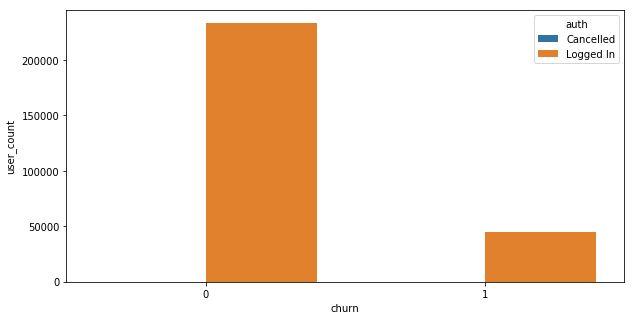

In [27]:
#distribution of auth and churned users
print("Below is the distribution for column {}".format('auth'))
df_temp = sparkify_dfp.groupby(['auth','churn'])['churn'].count().reset_index(level='auth')
df_temp.columns = ['auth','user_count']
df_temp = df_temp.reset_index()
sns.barplot(x="churn",y="user_count",hue="auth",data=df_temp)

Mostly users Logged In

From our analysis:

- More male users than female users using the service and the number of events corresponding to male users is greater than the number of events for female users.

- There are fewer paid level users than free level users, but the number of events for paid users is greater than the number of events for free level users. This means that paid level users are more active users of the service.

In [28]:
sparkify_dfp.columns

Index(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
       'length', 'level', 'location', 'method', 'page', 'registration',
       'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'churn'],
      dtype='object')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [29]:
#converting to int as the time is in exponential form
sparkify_dfp['registration'] = sparkify_dfp['registration'].astype(int)

In [30]:
#converting the pandas dataframe to spark dataframe
sparkify_dfs = spark.createDataFrame(sparkify_dfp)

In [31]:
# convert unix timestamp to actual to create more features like month, day, year, hour etc.,
def convert_ux_datetime(unix_timestamp):
    """Converts given ns to ms"""
    if unix_timestamp is None:
        return None
    return unix_timestamp//1000

convert_ux_datetime_udf = psqf.udf(convert_ux_datetime, psqt.LongType())

sparkify_dfs = sparkify_dfs.withColumn('ts_datetime', convert_ux_datetime_udf(sparkify_dfs.ts).cast('timestamp'))
sparkify_dfs = sparkify_dfs.withColumn('registration_datetime', convert_ux_datetime_udf(sparkify_dfs.registration).cast('timestamp'))

sparkify_dfs.select('ts', 'ts_datetime', 'registration', 'registration_datetime').show(5)

+-------------+-------------------+-------------+---------------------+
|           ts|        ts_datetime| registration|registration_datetime|
+-------------+-------------------+-------------+---------------------+
|1538352117000|2018-10-01 00:01:57|1538173362000|  2018-09-28 22:22:42|
|1538352180000|2018-10-01 00:03:00|1538331630000|  2018-09-30 18:20:30|
|1538352394000|2018-10-01 00:06:34|1538173362000|  2018-09-28 22:22:42|
|1538352416000|2018-10-01 00:06:56|1538331630000|  2018-09-30 18:20:30|
|1538352676000|2018-10-01 00:11:16|1538173362000|  2018-09-28 22:22:42|
+-------------+-------------------+-------------+---------------------+
only showing top 5 rows



In [32]:
sparkify_dfs.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- ts_datetime: timestamp (nullable = true)
 |-- registration_datetime: timestamp (nullable = true)



In [33]:
#top 5 rows of spark dataframe
sparkify_dfs.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------------+---------------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|        ts_datetime|registration_datetime|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------------+---------------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|

In [34]:
#lets a unique user Ids and churn labels
user_churn = sparkify_dfs.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))

In [35]:
# As per the above exploration, we see a clear distinction between free and paid
user_paid = sparkify_dfs.groupby("userId", "level").agg(max(sparkify_dfs.ts).alias("max_time")).sort("userId")
user_max_time = user_paid.groupby("userId").agg(max(user_paid.max_time).alias("recent"))
user_level = user_max_time.join(user_paid, [user_paid.userId == user_max_time.userId, user_max_time.recent == user_paid.max_time]).select(user_paid.userId, "level").sort("userId")
user_level = user_level.replace(["free", "paid"], ["0", "1"], "level")
user_level = user_level.select("userId", user_level.level.cast("int"))

In [36]:
# As per the above exploration, we see users attempt to listen to songs often
user_artist_count = sparkify_dfs.filter(sparkify_dfs.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritst_count")

In [37]:
# get all the type of page
page_list = [(row['page']) for row in sparkify_dfs.select("page").dropDuplicates().collect()]

# removing the value which we used to labeling churn, if not there will be a data leakage
page_list.remove("Cancellation Confirmation")

# caculate the total page each user view
user_page_view_count = sparkify_dfs.groupby("userId").count()
user_page_view_count = user_page_view_count.withColumnRenamed("count", "page_count")

for page in page_list:
    col_name = "count" + page.replace(" ", "")
    view_count = sparkify_dfs.filter(sparkify_dfs.page==page).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userId_temp")
    user_page_view_count = user_page_view_count.join(view_count, user_page_view_count.userId==view_count.userId_temp, "left").drop("userId_temp")
user_page_view_count = user_page_view_count.sort("userId")
user_page_view_count = user_page_view_count.fillna(0)

In [38]:
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("page_count")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(page_count/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_count.createOrReplaceTempView("user_page_view_count")
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("page_count")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(page_count/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_freq = spark.sql(freq_sql)

In [39]:
#converting the gender columns to numerical
user_gender = sparkify_dfs.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

In [40]:
### number of days users using service from the registration
user_ts_max = sparkify_dfs.groupby("userId").max("ts").sort("userId")
user_ts_reg = sparkify_dfs.select("userId", "registration").dropDuplicates().sort("userId")
user_days = user_ts_reg.join(user_ts_max, user_ts_reg.userId == user_ts_max.userId).select(user_ts_reg["userId"], ((user_ts_max["max(ts)"]-user_ts_reg["registration"])/(1000*60*60*24)).alias("regDay"))

In [41]:
#descriptive stats for user sessions
user_session_time = sparkify_dfs.groupby("userId", "sessionId").agg(((max(sparkify_dfs.ts)-min(sparkify_dfs.ts))/(1000*60)).alias("session_time"))
user_session_time_des_stat = user_session_time.groupby("userId").agg(avg(user_session_time.session_time).alias("sessiontime_avg"), min(user_session_time.session_time).alias("sessiontime_min"), max(user_session_time.session_time).alias("sessiontime_max")).sort("userId")


In [42]:
#descriptive stats for user sessions songs
user_session_songs = sparkify_dfs.filter(sparkify_dfs.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_des_stat = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("sessionsongs_avg"), min(user_session_songs["count"]).alias("sessionsongs_min"), max(user_session_songs["count"]).alias("sessionsongs_max")).sort("userId")

In [43]:
user_session_songs_des_stat.show(5)

+------+------------------+----------------+----------------+
|userId|  sessionsongs_avg|sessionsongs_min|sessionsongs_max|
+------+------------------+----------------+----------------+
|    10|112.16666666666667|              21|             381|
|   100| 78.88235294117646|               2|             256|
|100001|             33.25|              12|              53|
|100002|             48.75|               1|             175|
|100003|              25.5|               2|              49|
+------+------------------+----------------+----------------+
only showing top 5 rows



In [44]:
#user session counts
user_session_count = sparkify_dfs.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "session_count")

In [45]:
# combining all the features into a list
features_list = []

features = [user_session_count, user_days, user_session_songs_des_stat, user_session_time_des_stat,
            user_gender, user_page_view_freq, user_artist_count, user_level, user_churn]

for feat in features:
    features_list.append(feat)

In [46]:
# prepare the final dataframe to join all the other features
sparkify_dfs_new = sparkify_dfs.select("userId").dropDuplicates()

In [47]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userId_temp")
    df = df1.join(df2, df1.userId == df2.userId_temp, "left").drop("userId_temp")
    return df

In [48]:
# use function to merge the features in the list
for feature in features_list:
    sparkify_dfs_new = features_merge(sparkify_dfs_new, feature)
sparkify_dfs_new.persist()

DataFrame[userId: string, session_count: bigint, regDay: double, sessionsongs_avg: double, sessionsongs_min: bigint, sessionsongs_max: bigint, sessiontime_avg: double, sessiontime_min: double, sessiontime_max: double, gender: int, freqCancel: double, freqSubmitDowngrade: double, freqThumbsDown: double, freqHome: double, freqDowngrade: double, freqRollAdvert: double, freqLogout: double, freqSaveSettings: double, freqAbout: double, freqSettings: double, freqAddtoPlaylist: double, freqAddFriend: double, freqNextSong: double, freqThumbsUp: double, freqHelp: double, freqUpgrade: double, freqError: double, freqSubmitUpgrade: double, aritst_count: bigint, level: int, churn: int]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [49]:
sparkify_dfs_new.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



Yes, thie same distribution when we plot the churn distribution

In [181]:
#lets save this dataframe to a file, where we could reuse
sparkify_dfs_new.write.save("mini_sparkify_event_data_new_v1.csv", format="csv", header=True)

In [50]:
sparkify_dfs_new = spark.read.csv("mini_sparkify_event_data_new_v1.csv", header=True)
sparkify_dfs_new.persist()

DataFrame[userId: string, sessionCount: string, regDay: string, sessionsongs_avg: string, sessionsongs_min: string, sessionsongs_max: string, sessiontime_avg: string, sessiontime_min: string, sessiontime_max: string, gender: string, freqCancel: string, freqSubmitDowngrade: string, freqThumbsDown: string, freqHome: string, freqDowngrade: string, freqRollAdvert: string, freqLogout: string, freqSaveSettings: string, freqAbout: string, freqSettings: string, freqAddtoPlaylist: string, freqAddFriend: string, freqNextSong: string, freqThumbsUp: string, freqHelp: string, freqUpgrade: string, freqError: string, freqSubmitUpgrade: string, aritst_count: string, level: string, churn: string]

In [51]:
#converting all the columns to numeric
num_features_list = sparkify_dfs_new.columns[1:]
for feat in num_features_list:
    feat_name = feat + "_num"
    sparkify_dfs_new = sparkify_dfs_new.withColumn(feat_name, sparkify_dfs_new[feat].cast("float"))
    sparkify_dfs_new = sparkify_dfs_new.drop(feat)

In [52]:
#storing the features as a vector
vector_assembler = VectorAssembler(inputCols=sparkify_dfs_new.columns[1:-1], outputCol="num_features")
features_calc = vector_assembler.transform(sparkify_dfs_new)

In [53]:
#standardizing the values, for faster convergence
scaler = StandardScaler(inputCol="num_features", outputCol="scaled_num_features", withStd=True)
scaled_features = scaler.fit(features_calc)
features_calc = scaled_features.transform(features_calc)

In [54]:
#labels and features
sparkify_data = features_calc.select(features_calc.churn_num.alias("label"), features_calc.scaled_num_features.alias("features"))

In [55]:
#splitting the data to train and test
train, test = sparkify_data.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

#### Logistic Regression

In [56]:
model_lr =  LogisticRegression()
params = ParamGridBuilder() \
    .addGrid(model_lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(model_lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval_lr = CrossValidator(estimator=model_lr,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)
cv_lr = crossval_lr.fit(train)

In [57]:
#best cv model
bestModel_lr = cv_lr.bestModel

In [194]:
#persist the model for later use
cv_lr.save('cv_lr.model')

In [196]:
print('Best Param (regParam): ', bestModel_lr._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', bestModel_lr._java_obj.getElasticNetParam())

Best Param (regParam):  0.0
Best Param (elasticNetParam):  0.0


In [58]:
cv_lr.avgMetrics

[0.8530544656015253,
 0.7994144500812196,
 0.7899669465411594,
 0.8530544656015253,
 0.8169948762098229,
 0.7433563176043,
 0.8530544656015253,
 0.8132645168037943,
 0.7380272163060007,
 0.8530544656015253,
 0.7860017854123246,
 0.7124529057587252]

In [59]:
predictions = cv_lr.transform(test)

In [60]:
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 0.821056


#### Random Forest

In [61]:
model_rf = RandomForestClassifier()
params = ParamGridBuilder() \
    .addGrid(model_rf.numTrees,[50, 100, 150]) \
    .addGrid(model_rf.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_rf = CrossValidator(estimator=model_rf,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cv_rf = crossval_rf.fit(train)
cv_rf.avgMetrics

[0.9892217756667883,
 1.0,
 1.0,
 1.0,
 0.9721076885762794,
 1.0,
 1.0,
 1.0,
 0.9717327974998746,
 1.0,
 1.0,
 1.0]

In [62]:
predictions = cv_rf.transform(test)

In [63]:
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 1


Seems to be overfitting

#### Undersampling, penalizing to optimize F1 score as the labels are imbalance

In [64]:
stratified_train = train.sampleBy('label', fractions={0: 52/173, 1: 1.0}).cache()
stratified_train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   40|
|  0.0|   53|
+-----+-----+



In [209]:
model_lr_strat =  LogisticRegression()
params = ParamGridBuilder() \
    .addGrid(model_lr_strat.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(model_lr_strat.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval_lr_strat = CrossValidator(estimator=model_lr_strat,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)
cv_lr_strat = crossval_lr_strat.fit(stratified_train)

In [221]:
#persist the model for later use
cv_lr_strat.save('cv_lr_strat_v2.model')

In [212]:
cv_lr_strat.avgMetrics

[0.5735667294910262,
 0.6597819255907491,
 0.6744490231990232,
 0.5735667294910262,
 0.6863317009077878,
 0.6947664835164835,
 0.5735667294910262,
 0.7026311379252556,
 0.7154044974633209,
 0.5735667294910262,
 0.7567722729103803,
 0.7894025223202119]

In [213]:
predictions = cv_lr_strat.transform(test)
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 0.700491


In [66]:
model_rf_strat = RandomForestClassifier()
params = ParamGridBuilder() \
    .addGrid(model_rf_strat.numTrees,[50, 100, 150]) \
    .addGrid(model_rf_strat.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_rf_strat = CrossValidator(estimator=model_rf_strat,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cv_rf_strat = crossval_rf_strat.fit(stratified_train)
cv_rf_strat.avgMetrics

[1.0,
 1.0,
 1.0,
 1.0,
 0.9893721978694441,
 0.9893721978694441,
 0.9893721978694441,
 0.9893721978694441,
 0.9893721978694441,
 0.9893721978694441,
 0.9893721978694441,
 0.9893721978694441]

In [67]:
predictions = cv_rf_strat.transform(test)
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 1


In [227]:
#best cv model
bestModel_lr_start = cv_lr_strat.bestModel

In [229]:
bestModel_lr_start.save('bestModel_lr_strat_best.model')

### Results

Respective to Logistic Regression, at first on the imbalance data, it seems overfitting. Then used undersampling to equal the data distribution and build a model.
Logistic Regression on undersampling data performing better, with proper tuning of parameters using cross validation.

Random Forest gave me good accuracy on imbalance data and also after taking care of imbalance. Random Forest in this performed better.

Can also create more features and see feature importance to choose the features and build a model then, which might give us better results

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.